# From a qualitative single-cell model to a population model

We have built a toy model showing the difference between the model outputs when we consider the status of the population or not in a feedback loop from a ligand to a receptor. 
The model can be interpreted as a cell differentiation between two cell types T1 and T2. 

The input node I activates a node A, which drives the differntiation into a T1 cell type. In parallel, the node A activates a ligand L, which in turn triggers a receptor R that drives the T2 cell type. To insure mutual exclusivity between the cell types, T2 is only activated in the absence of A and T1 is inhibited by some components of the cascade leading to the T2 cell type.

Here we show how to go from a qualitative model of a single cell to a probabilistic model of a single cell using bioLQM and MaBoSS, and then to a population-level model using UPMaBoSS. This approach can be used to turn a qualitative model into a population model in a reproducible way. It is particularly useful if we want to apply it to several versions of a qualitative single-cell model.

## Model at the single cell level

The following cells show how to load a qualitative model, convert it to a MaBoSS model and set a few simulation parameters. In this example, we start with a model in the bnet format for the sake of readability, but it would work just as well with a GINsim or SBML qual model.

In [1]:
import biolqm
import maboss


# Load the logical model in bioLQM and convert it to a MaBoSS stochastic model
mbs = biolqm.to_maboss( biolqm.load('toy.bnet') )

# Set the length of the simulation
mbs.update_parameters(max_time=20, sample_count=5000)

# Activate the input in the initial condition
maboss.set_nodes_istate(mbs, ["I"], [0, 1])

Now that we have a working MaBoSS model, we can run the simulation and display the results.

The pie chart shows the distribution of state probabilities at the end of the simulation, we can see that all trajectories lead to the T1 state.

The second chart show the trajectories of individual node probabilities along the simulation, showing successive waves of activation of components in the pathway.

CPU times: user 2.66 ms, sys: 4.92 ms, total: 7.59 ms
Wall time: 108 ms


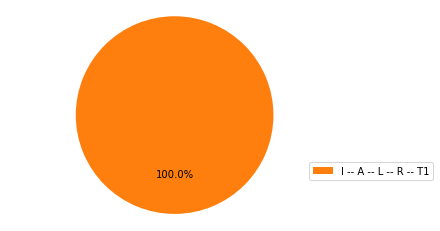

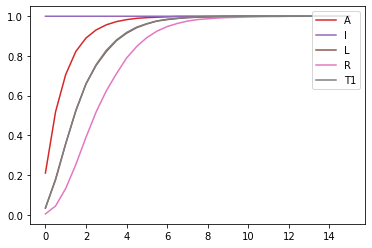

In [2]:
%time r = mbs.run()

# Plot the piechart and trajectories
r.plot_piechart()
r.plot_node_trajectory(until=15)

# Add rules for the population


In the model above, the ligand activates the receptor in the same cell (autocrine effect), however it could also activate the receptor of neighbour cells (paracrine effect). To account for this effect, we will slightly modify the single-cell model to add a parameter representing the amount of ligand produced by the whole cell population. This parameter is then used to trigger the activation of the receptor.


We then show that accounting for this population effect enables the activation of T2.

In [3]:
# Work on a copy of the single-cell model, to keep the original one
outer_mbs = mbs.copy()

 # Update simulation parameters
outer_mbs.update_parameters(max_time=1, time_tick=0.1)

# Add a new parameter for the external ligand, absent in the initial condition
outer_mbs.param["$outerL"] = 0

# Use this new parameter for the activation of the receptor.
# For simplicity we disable it's inactivation in this example.
outer_mbs.network.get("R").rt_up = "$outerL"
outer_mbs.network.get("R").rt_down = 0

In [4]:
# Create a population model using the maboss API
umbs = maboss.UpdatePopulation(outer_mbs)

# Set the number of simulation steps
umbs.setStepNumber(20)

# Set the rule to compute the value of the parameter representing the external ligand.
# In this example, the external ligand depends on the proportion of cells expressing the ligand.
umbs.setExternalVariable("$outerL", "5*p[(L) = (1)]")

In [5]:
# Alternatively, we can create the population model by loading a handwritten upp file
# This file provides the number of steps and the rule for the external variable
# This file is parsed and turned into the same API calls as above.
umbs = maboss.UpdatePopulation(outer_mbs, uppfile="ToyModelUP.upp")

Now that we have a population model, we can run the simulation and display the results.

The pie chart shows the distribution of state probabilities at the end of the simulation, we can see that most trajectories lead to the T1 state, but a subset of cells can now reach the T2 state.

The second chart show the trajectories of individual node probabilities along the simulation (based on snapshots at each step of the UPMaBoSS simulation). Here we see that the receptor can now be activated in cells which do not express A, which enables the differentiation in the T2 state.

CPU times: user 67.8 ms, sys: 78.9 ms, total: 147 ms
Wall time: 716 ms


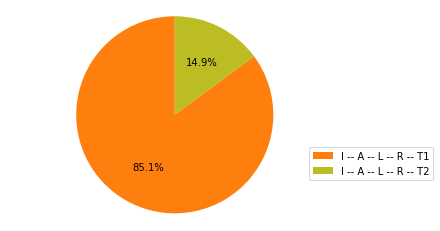

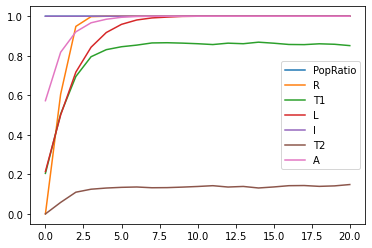

In [6]:
%time ur = umbs.run()

# Plot the probability distribution at the end of the last step
ur.results[-1].plot_piechart()

# Extract and plot the stepwise trajectories of individual components (nodes)
traj = ur.get_nodes_stepwise_probability_distribution()
p = traj.plot()

## Going further: inside the generated MaBoSS files

To better understand the definition of MaBoSS models, we can have a look at the original bnet file and the generated network (bnd) and configuration (cfg) files generated in this example. The original bnd file and the one used for the population differ only in the definition of rate_up and rate_down of the receptor. The cfg file used for the population includes an additional parameter for the external ligand ($outer_L).


In a separate notebook, we show a variant of this example using handcrafted MaBoSS files, which allows greater flexibility. In particular we show how both variants of the model can be manually encoded in a single model, using an additional parameter to switch between both versions.

In [7]:
# Display the original BNET file, and the generated MaBoSS network and configuration files
print("--------------------------- BNET file ---------------------------\n")
!cat toy.bnet
print("\n--------------------------- BND file ---------------------------\n")
mbs.print_bnd()
print("\n--------------------------- CFG file---------------------------\n")
mbs.print_cfg()

--------------------------- BNET file ---------------------------

I, I
A, I
L, A
R, L
T1, A & !T2
T2, T2 | (R & !A)

--------------------------- BND file ---------------------------

Node I {

	logic = (I);
	rate_up = @logic ? $u_I : 0;
	rate_down = @logic ? 0 : $d_I;
}
Node A {

	logic = (I);
	rate_up = @logic ? $u_A : 0;
	rate_down = @logic ? 0 : $d_A;
}

Node L {

	logic = (A);
	rate_up = @logic ? $u_L : 0;
	rate_down = @logic ? 0 : $d_L;
}

Node R {

	logic = (L);
	rate_up = @logic ? $u_R : 0;
	rate_down = @logic ? 0 : $d_R;
}

Node T1 {

	logic = (A & !T2);
	rate_up = @logic ? $u_T1 : 0;
	rate_down = @logic ? 0 : $d_T1;
}

Node T2 {

	logic = (!A & !R & T2) | (!A & R) | (A & T2);
	rate_up = @logic ? $u_T2 : 0;
	rate_down = @logic ? 0 : $d_T2;
}

--------------------------- CFG file---------------------------

$nb_mutable = 0;
$u_I = 1;
$d_I = 1;
$u_A = 1;
$d_A = 1;
$u_L = 1;
$d_L = 1;
$u_R = 1;
$d_R = 1;
$u_T1 = 1;
$d_T1 = 1;
$u_T2 = 1;
$d_T2 = 1;
I.istate = TRUE;
A.istate = FALS

In [8]:
# Show the modified MaBoSS files
print("\n--------------------------- UPP file ---------------------------\n")
with open("ToyModelUP.upp") as f:
    print( f.read() )
print("\n--------------------------- BND file ---------------------------\n")
outer_mbs.print_bnd()
print("\n--------------------------- CFG file ---------------------------\n")
outer_mbs.print_cfg()


--------------------------- UPP file ---------------------------

$outerL u= 5*p[(L) = (1)];
steps = 20;


--------------------------- BND file ---------------------------

Node I {

	logic = (I);
	rate_up = @logic ? $u_I : 0;
	rate_down = @logic ? 0 : $d_I;
}
Node A {

	logic = (I);
	rate_up = @logic ? $u_A : 0;
	rate_down = @logic ? 0 : $d_A;
}

Node L {

	logic = (A);
	rate_up = @logic ? $u_L : 0;
	rate_down = @logic ? 0 : $d_L;
}

Node R {

	logic = (L);
	rate_up = $outerL;
	rate_down = 0;
}

Node T1 {

	logic = (A & !T2);
	rate_up = @logic ? $u_T1 : 0;
	rate_down = @logic ? 0 : $d_T1;
}

Node T2 {

	logic = (!A & !R & T2) | (!A & R) | (A & T2);
	rate_up = @logic ? $u_T2 : 0;
	rate_down = @logic ? 0 : $d_T2;
}

--------------------------- CFG file ---------------------------

$nb_mutable = 0;
$u_I = 1;
$d_I = 1;
$u_A = 1;
$d_A = 1;
$u_L = 1;
$d_L = 1;
$u_R = 1;
$d_R = 1;
$u_T1 = 1;
$d_T1 = 1;
$u_T2 = 1;
$d_T2 = 1;
$outerL = 0;
I.istate = TRUE;
A.istate = FALSE;
L.istate = FALSE;
R